# The plane wave solver

For smooth potentials, the finite difference solver in `FDSolver` is usually overkill and a planewave expansion method much faster. Such a plane-wave solver is implemented in the class `PWSolver` of the `pwsolver` submodule.

The plane wave method consists in expanding the bloch eigenvectors in a small plane wave basis, converting the differencial Schrödinger-Bloch equation into a much smaller algebraic equation. For very smooth potentials, only a few hundred plane waves are enough to reach convergence, drastically reducing the size of the eigenproblem to solve.

## Theory

We want to solve the Schrödinger-Bloch equation for a single unit cell

$$\left[-\frac{\hbar^2}{2 m_c} (\mathbf{\nabla} + i \mathbf{k})^2 + V(\mathbf{r}) \right] u_{\mathbf{k}}^n(\mathbf{r}) = \delta E u_{\mathbf{k}}^n(\mathbf{r})$$

Since both $V(\mathbf{r})$ and $u_{\mathbf{k}}^n(\mathbf{r})$ are periodic functions, we can write them as sums of plane waves:

$$\begin{gather}
u(\mathbf{r}) = \sum_{\mathbf{G}} c_{\mathbf{G}} e^{i \mathbf{G} \cdot \mathbf{r}} \\
V(\mathbf{r}) = \sum_{\mathbf{G}'} V_{\mathbf{G}'} e^{i \mathbf{G}' \cdot \mathbf{r}}
\end{gather}$$

where $\mathbf{G}, \mathbf{G}'$ are reciprocal space vectors and where we have dropped the $k, n$ indices.

By substituting this expressions into the Scrödinger-Bloch equation, we can easily arrive to the central equation:

$$\frac{\hbar^2}{2m} |\mathbf{k} + \mathbf{G}|^2 c_{\mathbf{G}} + \sum_{\mathbf{G}'} V_{\mathbf{G}-\mathbf{G}'} c_{\mathbf{G}'} = E c_\mathbf{G}$$

This can be expressed as the eigenproblem $M_{\mathbf{G}'\mathbf{G}} c_{\mathbf{G}'} = E c_\mathbf{G}$ with

$$ M_{\mathbf{G}'\mathbf{G}} = \frac{\hbar^2}{2m} |\mathbf{k} + \mathbf{G}|^2 \delta_{\mathbf{G}'\mathbf{G}} + V_{\mathbf{G} - \mathbf{G}'}$$

## Energy cut-off 

The plane wave basis is in theory infinite, as there is infinitely many reciprocal vectors $\mathbf{G}$, hovewer, if the potential is smooth enough, then the $V_\mathbf{G}$ terms quickly fall to zero and it is possible to truncate the basis to a manageable size. In practice, we set a cut-off energy $E_{lim}$, such that the basis will be truncated to
$$\frac{\hbar^2 |\mathbf{G}|^2}{2m} < E_{lim}$$

## The PWSolver class

The `PWSolver` class is a specialized solver that can build the matrix form of the central equation, before performing batch eigen-decomposition. From the user's point of view, its use is very similar to the `FDSolver` class. Here we are going to show a simple use-case. We are going to build a honeycomb lattice made from the interference of 3 laser beams (see [[Lee2009]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.80.043411)), and then use the plane-wave solver to very efficiently compute its band and eigenvector structure.

First, let's define some quantities:

In [1]:

# Just a few imports
import numpy as np
import matplotlib.pyplot as plt
from bloch_schrodinger.potential import Potential, create_parameter
from bloch_schrodinger.plotting import plot_cuts, plot_eigenvector

# First, we define a few constants

kl = 2 # Laser wavevector
a = 4 * np.pi / 3**1.5 / kl # Lattice constant
a1 = np.array([3 * a / 2, -(3**0.5) * a / 2])  # 1st lattice vector
a2 = np.array([3 * a / 2, 3**0.5 * a / 2])  # 2nd lattice vector

# Reciprocal vectors
b1 = 3**0.5 * kl * np.array([1, -(3**0.5)]) / 2
b2 = 3**0.5 * kl * np.array([1, 3**0.5]) / 2

m = 1
hbar = 1
E_r = hbar**2 * kl**2 / 2 / m # Recoil energy

# --- We are going to create a honeycomb lattice with on-site energy differences ---
s1 = 20 # Laser intensity in recoil energy unit
s2 = s1 + create_parameter("delta", np.linspace(-0.3, 0.3, 3))

# Laser directions
k1 = kl * np.array([-(3**0.5) / 2, 1 / 2])
k2 = kl * np.array([3**0.5 / 2, 1 / 2])
k3 = kl * np.array([0, -1])

# Reciprocal space vectors
a1s = np.array([-1, 3**0.5]) * 2 * np.pi / 3 / a
a2s = np.array([1, 3**0.5]) * 2 * np.pi / 3 / a
K = np.array([0, 4 * np.pi / 3**1.5 / a])


Now, we build the potential exactly as for the finite-difference solver, using the `Potential` class. The only difference is that the potential resolution chosen is not going to affect the solver's performance (as long as the underlying potential is sampled enough, which is not going to be an issue here).

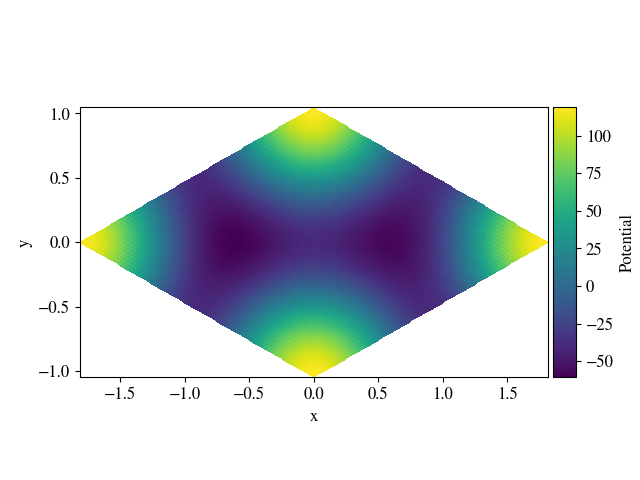

In [2]:

na1 = 64
na2 = 64

V1 = -s1 * E_r
V2 = -s2 * E_r

honeycomb = Potential(
    unitvecs=[a1, a2],
    resolution=(na1, na2),
    v0=0,
)

dirs = [
    k1[0] * (honeycomb.x - a1[0]) + k1[1] * honeycomb.y,
    k2[0] * (honeycomb.x - a1[0]) + k2[1] * honeycomb.y,
    k3[0] * (honeycomb.x - a1[0]) + k3[1] * honeycomb.y,
]

for i in range(3):
    honeycomb.add(2 * V1 * np.cos((dirs[i - 1] - dirs[i]) - 2 * np.pi / 3) / 2)
    honeycomb.add(2 * V2 * np.cos((dirs[i - 1] - dirs[i]) + 2 * np.pi / 3) / 2)

%matplotlib widget
honeycomb.plot()
plt.show()

Now that the potential is set, we can construct a `PWSolver` object. For now, this solver only supports the resolution of scalar equations, and, for plane-wave expansion, one cannot set the kinetic term $\hbar^2/2m$ as a parameter dimension. The inclusion of multiple field is planned to be supported at some point.

In [3]:
from bloch_schrodinger.pwsolver import PWSolver

alpha = 1
foo = PWSolver(
    potential = honeycomb, alpha = alpha, E_lim = 100*E_r
)

print(foo)

Plane wave Solver object 
 E_lim = 200.000 
 Expanded on 61 plane waves


The plane wave solver is instanciated by giving a `Potential` object, a value for the kinetic term $\hbar^2/2m$ and optionally the cut-off energy. If this last one is not given, a value equal to twice the energy range of the potential is used. At construction, it automatically Fourier transforms the potential array:

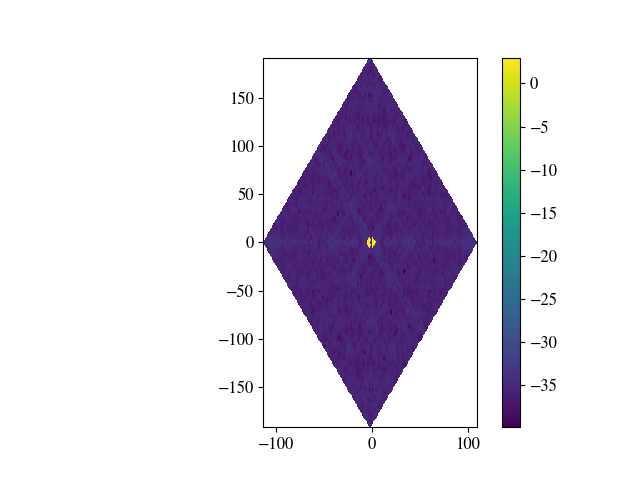

In [4]:
fig, ax = plt.subplots()
im = plt.pcolormesh(foo.pwkx, foo.pwky, np.log(abs(foo.fV.sel(delta = 0))))
plt.colorbar(im)
ax.set_aspect('equal')
plt.show(False)

Here we see the power of the plane-wave method. As the potential is already a sum of plane waves, only a few (6) elements are non-zero, which justifies the aggressive basis truncation.

Now, we are going to define a reciprocal space grid on which to solve, and then run the actual solver.

Performing 165 diagonalizations...


  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [00:00<00:00, 384.94it/s]


storing the results


100%|██████████| 165/165 [00:00<00:00, 1078.17it/s]


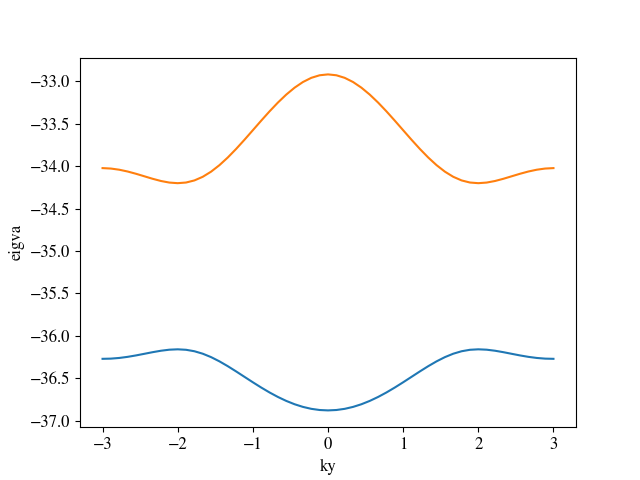

In [5]:

foo.create_reciprocal_grid(
    ky=np.linspace(-a1s[1], a1s[1], 55), # Solving for 55 k-points
    kx=0,
)

eigva, eigve = foo.solve(
    n_eigva=2 # The solve function only needs the number of eigenvalues for which to solve
)

plot_cuts(eigva, "ky")
plt.show()

As one can see, the solver is extremely fast (compared to the `FDSolver` on the same potential). This is expected, are we only have to diagonalize matrices of size $61 \times 61$, whereas the FDSolver would have to diagonalize matrices of size $64^2 \times 64^2$ (same resolution as the potential). The PWSolver class also implement a simple parallelized version of the solve method, the `parallel_solve` method.

Before displaying the results and comparing them to the finite-difference solver, let's look at the resulting eigve array (the eigenvalues array returned `eigva` is the same as for the `FDSolver`).

In [6]:
print(eigve.shape)
print(eigve.coords)

(61, 2, 3, 55)
Coordinates:
  * g        (g) int64 488B 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
  * band     (band) int64 16B 0 1
  * delta    (delta) float64 24B -0.3 0.0 0.3
  * ky       (ky) float64 440B -3.0 -2.889 -2.778 -2.667 ... 2.778 2.889 3.0
    kx       int64 8B 0
    pwka1    (g) int64 488B -4 -4 -4 -4 -4 -3 -3 -3 -3 -3 ... 3 3 3 3 4 4 4 4 4
    pwka2    (g) int64 488B -4 -3 -2 -1 0 -4 -3 -2 -1 0 ... 0 1 2 3 4 0 1 2 3 4
    pwkx     (g) float64 488B -13.86 -12.12 -10.39 -8.66 ... 10.39 12.12 13.86
    pwky     (g) float64 488B 0.0 3.0 6.0 9.0 12.0 ... -12.0 -9.0 -6.0 -3.0 0.0


The `eigve` array is a $(N_G, N_{bands}, ...)$-shaped xarray with $N_G$ the number of reciprocal vectors $\mathbf{G}$ used for the expansion and $N_{bands}$ the number of eigenvalues asked. Additional dimensions are used to store the parameter dimensions, such as position in k-space or potential parameter dimensions. The `eigve` array is a lightweight object that only stores the coefficient $c_{\mathbf{G}}$ (as well as the expression of each vector $\mathbf{G}$). This form is very convenient for eigenvector manipulation, and it can be used to quickly compute the actual bloch eigenvectors $u^n_{\mathbf{k}} (\mathbf{r})$, using the `compute_u` class method.

summing...


100%|██████████| 61/61 [00:00<00:00, 89.86it/s]


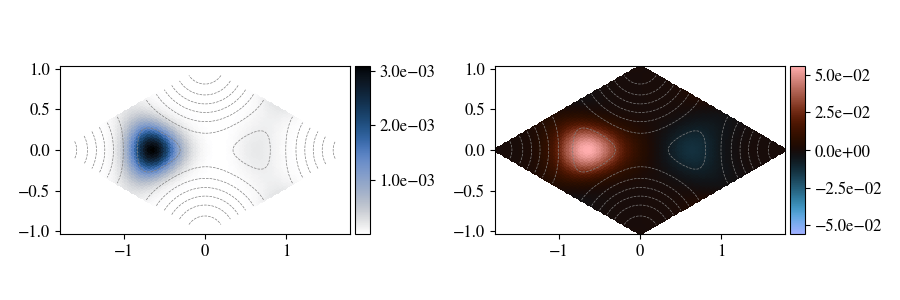

In [7]:

ukn = foo.compute_u(
    eigve,
    x = None,           # Custom x and y grids where to sample the mode profiles can be given as DataArrays.
    y = None,           #  If None are given, the grid of the potential object is used by default.
)                       

plot_eigenvector(
    [[abs(ukn)**2, ukn.real]], [[honeycomb, honeycomb]], [['amplitude', 'real']]
)
plt.show()

## Comparison to finite differences

Thanks to the class uniformization, we can easily compare the results to the finite differences solver.

In [8]:
from bloch_schrodinger.fdsolver import FDSolver

bar = FDSolver(honeycomb, alpha)

bar.create_reciprocal_grid(    
    ky=np.linspace(-a1s[1], a1s[1], 55),
    kx=0,
)

eigva_fd, eigve_fd = bar.solve(
    n_eigva=2,
)

Performing 165 diagonalizations...


100%|██████████| 165/165 [00:42<00:00,  3.86it/s]


storing the results


100%|██████████| 165/165 [00:00<00:00, 970.63it/s]


One can see that in this case, the finite difference solver is roughly 20 times slower than the plane wave solver. Of course, here we are in very favorable circumstances for the latter.

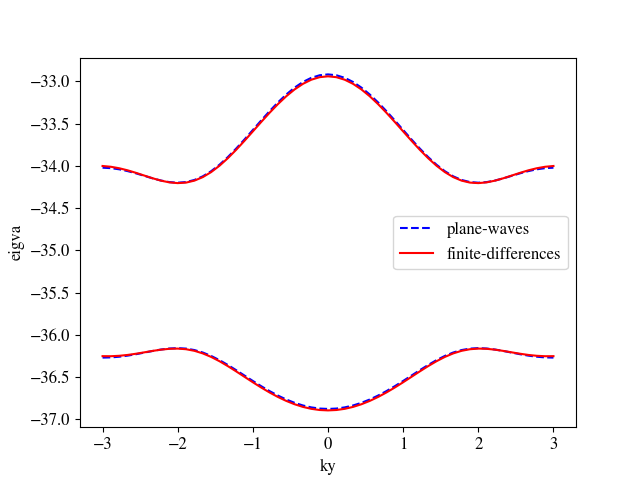

In [9]:
# Let's compare the band structure
import xarray as xr
eigva.coords['band'] = 2*np.arange(2)
eigva_fd.coords['band'] = 2*np.arange(2)+1

eigva_tot = xr.concat([eigva, eigva_fd], dim = 'band').sortby('band') # Using the concat method, we combine the bands structure.

template_pw = {"color":"blue", "linestyle":'dashed'}
template_fd = {"color":"red"}

fig, ax = plot_cuts(eigva_tot, 'ky', linekws = [template_pw, template_fd]) # we specify the templates for each lines, to distinguish between 2d bands and tightbinding bands
ax.legend(['plane-waves', 'finite-differences'])
plt.show()

We observe very similar band structures. This is a good indication that both solvers are converged. Slight differences exists near the $\Gamma$ and $M$ points. In this situation, the plane-wave solver is more accurate, and should be prefered over the finite-difference solver. Below, we recapitulate the main differences between both approaches.


||Plane-waves|Finite differences|
|:--:|:--:|:--:|
|potential smoothness|very important|Don't care much|
|potential resolution|don't affect speed|slows down a lot as the resolution increases|
|solution anisotropy|never|almost never (large FD stencils are used)|
|Energy cut-off|Must be specified| / |